# **TASK 1**

# 0. Setup

## 0.1. Import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import pie, show

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from imblearn.over_sampling import ADASYN

## 0.2 Utilities

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_df = True
rm_nan = False

In [ ]:
df_path = '/content/drive/MyDrive/progetto-ml/data/'

In [ ]:
macro_cardiovascular_events = ['AMD047', 'AMD048', 'AMD049', 'AMD071', 'AMD081', 'AMD082', 'AMD208', 'AMD303']

In [ ]:
def get_class_distribution(patientsBefore, patientsAfter):
  return round((patientsAfter/patientsBefore)*100, 2)

In [ ]:
def print_distribution(step_n0, step_n1, str1="Entries kept:", str2="Entries Discarded:"):
  interest = get_class_distribution(step_n0, step_n1)
  discarded = round(100-interest, 2)
  print(str1, step_n0)
  print(str2, step_n1)
  print(str1, interest, "%")
  print(str2, interest, "%")
  labels = [str2, str1]
  pie([interest, discarded], labels = labels, autopct = '%1.1f%%')
  show()

In [ ]:
def filter_df_patients(target, patients):
  return pd.merge(target, patients, on=['idcentro', 'idana'], how='inner')

## 0.3. Load in the datasets

In [ ]:
anagrafica_pazienti_attivi = pd.read_csv(df_path+'anagraficapazientiattivi.csv')
diagnosi = pd.read_csv(df_path+'diagnosi.csv')

In [ ]:
# prescriptions
prescrizioni_non_diabete = pd.read_csv(df_path+'prescrizioninondiabete.csv')
prescrizioni_diabete_farmaci = pd.read_csv(df_path+'prescrizionidiabetefarmaci.csv')
prescrizioni_diabete_non_farmaci = pd.read_csv(df_path+'prescrizionidiabetenonfarmaci.csv')

In [ ]:
# exams
esami_strumentali = pd.read_csv(df_path+'esamistrumentali.csv')
esami_laboratorio_parametri = pd.read_csv(df_path+'esamilaboratorioparametri.csv')
esami_laboratorio_parametri_calcolati = pd.read_csv(df_path+'esamilaboratorioparametricalcolati.csv')

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

## 0.4 Remove NaN

Consider other cleaning strategies that improve the dataset’s quality. How do you measure the quality before and after performing your cleaning strategy?

Deal with **missing values**

In [ ]:
check_nans_DFs = [anagrafica_pazienti_attivi, #. 00
       prescrizioni_non_diabete, # . . . . . . . 01
       prescrizioni_diabete_farmaci, # . . . . . 02
       prescrizioni_diabete_non_farmaci, # . . . 03
       esami_strumentali, #. . . . . . . . . . . 04
       esami_laboratorio_parametri, #. . . . . . 05
       esami_laboratorio_parametri_calcolati, #. 06
       #diagnosi #. . . . . . . . . . . . . . . . 08
]

In [ ]:
def get_macro_events(df):
    return df[df['codiceamd'].isin(macro_cardiovascular_events)]

In [ ]:
# check amount of NaN values
i = 3
print(check_nans_DFs[i].isnull().sum())

Unnamed: 0        0
idcentro          0
idana             0
data              0
codiceamd         0
valore        48492
dtype: int64


In [ ]:
if rm_nan:
    new_DFs = []
    for df in check_nans_DFs:
        new_df = df.dropna(axis=0)
        new_DFs.append(new_df)

In [ ]:
check_nans_DFs = [
       prescrizioni_non_diabete, # . . . . . . . 00
       prescrizioni_diabete_farmaci, # . . . . . 01
       prescrizioni_diabete_non_farmaci, # . . . 02
       esami_strumentali, #. . . . . . . . . . . 03
       esami_laboratorio_parametri, #. . . . . . 04
       esami_laboratorio_parametri_calcolati, #. 05
       #diagnosi #. . . . . . . . . . . . . . . . 06
]
if rm_nan:
    if save_df:
        new_DFs[0].to_csv(df_path+'no_nan_prescrizioni_non_diabete.csv')
        new_DFs[1].to_csv(df_path+'no_nan_prescrizioni_diabete_farmaci.csv')
        new_DFs[2].to_csv(df_path+'no_nan_prescrizioni_diabete_non_farmaci.csv')
        new_DFs[3].to_csv(df_path+'no_nan_esami_strumentali.csv')
        new_DFs[4].to_csv(df_path+'no_nan_esami_laboratorio_parametri.csv')
        new_DFs[5].to_csv(df_path+'no_nan_esami_laboratorio_parametri_calcolati.csv')
        #new_DFs[6].to_csv(df_path+'no_nan_diagnosi.csv')

    #diagnosi = new_DFs[6]
    prescrizioni_non_diabete = new_DFs[0]
    prescrizioni_diabete_farmaci = new_DFs[1]
    prescrizioni_diabete_non_farmaci = new_DFs[2]
    esami_strumentali = new_DFs[3]
    esami_laboratorio_parametri = new_DFs[4]
    esami_laboratorio_parametri_calcolati = new_DFs[5]

    DFs = [
        diagnosi,
        prescrizioni_non_diabete,
        prescrizioni_diabete_farmaci,
        prescrizioni_diabete_non_farmaci,
        esami_strumentali,
        esami_laboratorio_parametri,
        esami_laboratorio_parametri_calcolati
    ]

# 1. Select patients with events of interest

We want only patients with at least one cardiovascular event in their trajectories.

In [ ]:
new_diagnosi = diagnosi.drop(columns=df.columns[0], axis=1)
new_diagnosi.head()

,idcentro,idana,data,codiceamd,valore
0,1,5,1980-01-01,AMD247,491.20
1,1,5,1986-01-01,AMD247,272.0
2,1,5,1987-01-01,AMD083,NaN
3,1,5,1987-01-01,AMD247,401
4,1,5,1997-12-01,AMD247,410


In [ ]:
tmp_diagnosi = new_diagnosi[new_diagnosi['codiceamd'].isin(macro_cardiovascular_events)]
print('All entries: ' + str(diagnosi.shape[0]))
print('Macro events: ' + str(tmp_diagnosi.shape[0]))

All entries: 4427337
Macro events: 233204


In [ ]:
tmp_pazienti = tmp_diagnosi[['idcentro','idana']].drop_duplicates().reset_index(drop=True)
tmp_pazienti.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,61
4,1,65


In [ ]:
# only keep diagnosi entries for patiens with at least onne macro event in their trajectory
new_diagnosi = filter_df_patients(diagnosi, tmp_pazienti)

In [ ]:
anagrafica_pazienti_attivi.drop(columns=diagnosi.columns[0], axis=1)
anagrafica_pazienti_attivi.head()

,Unnamed: 0,idcentro,idana,sesso,annodiagnosidiabete,tipodiabete,scolarita,statocivile,professione,origine,annonascita,annoprimoaccesso,annodecesso
0,0,89,13370,M,2007.0,5,NaN,NaN,NaN,NaN,1946,NaN,NaN
1,1,100,3080,M,1988.0,5,NaN,NaN,NaN,NaN,1936,1991.0,NaN
2,2,72,15730,M,2015.0,5,NaN,NaN,NaN,NaN,1965,2015.0,NaN
3,3,150,3799,F,1986.0,5,NaN,NaN,NaN,NaN,1928,NaN,NaN
4,4,141,4432,F,2010.0,5,NaN,NaN,NaN,NaN,1949,2011.0,NaN


Entries kept: 250000
Entries Discarded: 50000
Entries kept: 20.0 %
Entries Discarded: 20.0 %


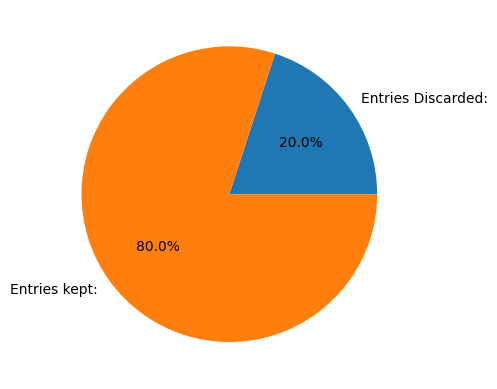

In [ ]:
before_subtask_1 = anagrafica_pazienti_attivi.shape[0]
new_anagrafica_pazienti_attivi = filter_df_patients(anagrafica_pazienti_attivi, tmp_pazienti)
after_subtask_1 = new_anagrafica_pazienti_attivi.shape[0]
print_distribution(before_subtask_1, after_subtask_1)

In [ ]:
# save the file for future reference
if save_df:
    tmp_pazienti.to_csv(df_path+'event_of_interest_patients.csv')
events_of_interest_patients = tmp_pazienti

In [ ]:
del tmp_pazienti
del tmp_diagnosi
del new_diagnosi

# 2. Invalid rows cleaning

check for dates and time intervals [x, y] such that y < x and not x ≤ y. Check for years that do not make sense (e.g., events before the birth of a particular patient).

In [ ]:
def rm_invalid(target_df, anagrafica_df):
  # only take events of patients in anagrafica_df
  tmp_df = pd.merge(target_df, anagrafica_df, on=['idcentro', 'idana'], how='inner')
  tmp_df = tmp_df[tmp_df['data'].notna()] # and only take events that have a date

  tmp_df['dataanno'] = tmp_df['data'].str[:4].astype(int) # year
  tmp_df['datamese'] = tmp_df['data'].str[5:7].astype(int) # month
  tmp_df['datagiorno'] = tmp_df['data'].str[8:].astype(int) # day

  c1 = tmp_df['dataanno']>tmp_df['annonascita']
  c2 = tmp_df['dataanno']<tmp_df['annodecesso']
  c3 = tmp_df['annodecesso'].isna()
  tmp_df = tmp_df[c1 & (c2 | c3)]
  tmp_df = tmp_df.drop(columns=['sesso', 'annodiagnosidiabete',	'tipodiabete', 'annonascita', 'annodecesso', 'dataanno', 'datamese', 'datagiorno', 'scolarita', 'statocivile', 'professione', 'origine', 'annoprimoaccesso'], axis=1)

  tmp_df = tmp_df.drop_duplicates(keep='first').reset_index(drop=True)
  return tmp_df

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

In [ ]:
event_of_interest_patients = pd.read_csv(df_path+'event_of_interest_patients.csv')
event_of_interest_patients = event_of_interest_patients.drop(columns=event_of_interest_patients.columns[0], axis=1)
event_of_interest_patients.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,46
4,1,60


In [ ]:
before_subtask_2 = 0
after_subtask_2 = 0

tmp_patients = filter_df_patients(anagrafica_pazienti_attivi, event_of_interest_patients)
new_DFs = []
for df in DFs:
    #df = df.drop(columns=df.columns[0], axis=1)
    before_subtask_2 += df.shape[0]
    new_df = rm_invalid(df, tmp_patients)
    after_subtask_2 += new_df.shape[0]
    new_DFs.append(new_df)

Entries kept: 57338410
Entries Discarded: 16340153
Entries kept: 28.5 %
Entries Discarded: 28.5 %


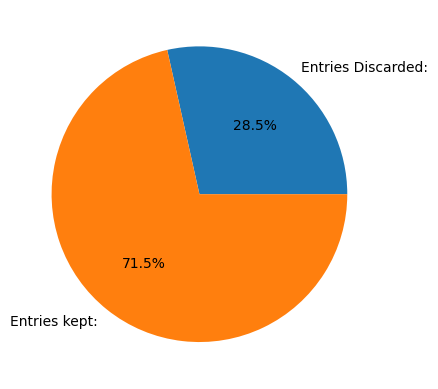

In [ ]:
print_distribution(before_subtask_2, after_subtask_2)

In [ ]:
del tmp_patients

In [ ]:
#new_DFs indexes
    # 0 - new_diagnosi,
    # 1 - new_prescrizioni_non_diabete,
    # 2 - new_prescrizioni_diabete_farmaci,
    # 3 - new_prescrizioni_diabete_non_farmaci,
    # 4 - new_esami_strumentali,
    # 5 - new_esami_laboratorio_parametri,
    # 6 - new_esami_laboratorio_parametri_calcolati
if save_df:
    new_DFs[0].to_csv(df_path+'new_diagnosi.csv')
    new_DFs[1].to_csv(df_path+'new_prescrizioni_non_diabete.csv')
    new_DFs[2].to_csv(df_path+'new_prescrizioni_diabete_farmaci.csv')
    new_DFs[3].to_csv(df_path+'new_prescrizioni_diabete_non_farmaci.csv')
    new_DFs[4].to_csv(df_path+'new_esami_strumentali.csv')
    new_DFs[5].to_csv(df_path+'new_esami_laboratorio_parametri.csv')
    new_DFs[6].to_csv(df_path+'new_esami_laboratorio_parametri_calcolati.csv')

In [ ]:
diagnosi = new_DFs[0]
prescrizioni_non_diabete = new_DFs[1]
prescrizioni_diabete_farmaci = new_DFs[2]
prescrizioni_diabete_non_farmaci = new_DFs[3]
esami_strumentali = new_DFs[4]
esami_laboratorio_parametri = new_DFs[5]
esami_laboratorio_parametri_calcolati = new_DFs[6]
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

In [ ]:
del new_DFs
del new_diagnosi
del event_of_interest_patients

# 3. Remove patients with all dates in the same month

We only want patients that have a long trajectory of examinations and diagnoses.

Given a dataframe and the idexes for columns with the the key (idcentro, idana) and the dates, the function returns a pandas DataFrame with the keys (idcentro, idana) that have at least one date in two different months.

The algoritm iterates on every row of the dataframe, checks whether the person has already been labeled as a long trajectory patient, if not then checks whether the date present in the row is different from the first date observed of the patient, if so then the patient is labeled as having a long trajectory and willl not be checked again

In [ ]:
def get_one_month_patients(target, patients):
  tmp_df = pd.merge(target, patients, on=['idcentro', 'idana'], how='inner')
  tmp_df = tmp_df[tmp_df['data'].notna()]

  tmp_df['anno'] = tmp_df['data'].str[:4].astype(int)
  tmp_df['mese'] = tmp_df['data'].str[5:7].astype(int)

  tmp_df = tmp_df.drop_duplicates(subset=['idcentro', 'idana', 'anno', 'mese'])
  tmp_df = tmp_df.reset_index(drop=True)
  tmp_df = tmp_df[['idcentro', 'idana']]
  tmp_df = tmp_df.groupby(['idcentro', 'idana']).size().reset_index(name='count')

  c1 = tmp_df['count'] == 1 # the patient has all dates in the same month
  tmp_df = tmp_df[c1] # keep only patients with all dates in the same month
  tmp_df = tmp_df.drop(columns=['count'], axis=1).reset_index(drop=True)

  return tmp_df

In [ ]:
def delete_one_month_patients(DFs, patients):
    # for eveery dataset given in input
    one_month_DFs = []
    for df in DFs[:3]:
        new_df = get_one_month_patients(df, patients)
        one_month_DFs.append(new_df)

    length = len(one_month_DFs)
    print(str(length) + ' ' + str(type(length)))

    tmp_df = one_month_DFs[0]
    # remove the patients with all dates in the same month from the dataset
    for i in range(1, length):
        tmp_df = pd.merge(tmp_df, one_month_DFs[i], how='inner', on=['idcentro', 'idana'])

    tmp_df = pd.merge(patients, tmp_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

    return tmp_df

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

In [ ]:
event_of_interest_patients = pd.read_csv(df_path+'event_of_interest_patients.csv')
event_of_interest_patients = event_of_interest_patients.drop(columns=event_of_interest_patients.columns[0], axis=1)
event_of_interest_patients.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,46
4,1,60


In [ ]:
long_trajectory_patients = delete_one_month_patients(DFs, event_of_interest_patients)
if save_df:
    long_trajectory_patients.to_csv(df_path+'long_trajectory_patients.csv')
long_trajectory_patients.head()

3 <class 'int'>


,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,46
4,1,60


# 4. Keep values within range

The values in esami_laboratorio_parametri aren't all legal values. We need to modify their ranges in order to keep them withing correct ranges.


AMD004 [40,200]

AMD005 [40,130]

AMD007 [50,500]

AMD008 [5,15]

AMD009 ???

AMD111 ???

STITCH001 ???

STITCH002 [30,300]

STITCH003 [60,330]

STITCH004 ???

STITCH005 ???

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

In [ ]:
actual_ranges = {
    'AMD004' : (40.0, 200.0),
    'AMD005' : (40.0, 130.0),
    'AMD007' : (50.0, 500.0),
    'AMD008' : (5.0, 15.0)
    #'STITCH002' : (30.0, 300.0),
    #'STITCH003' : (60, 330)
}

In [ ]:
esami_laboratorio_parametri.head()

,Unnamed: 0_x,idcentro,idana,data,codiceamd,valore,Unnamed: 0_y
0,0,1,5,2005-01-18,AMD001,169.0,169393
1,1,1,5,2005-01-18,AMD002,76.0,169393
2,2,1,5,2005-01-18,AMD004,135.0,169393
3,3,1,5,2005-01-18,AMD005,80.0,169393
4,4,1,5,2005-06-06,AMD007,169.0,169393


In [ ]:
counter = 0
df = esami_laboratorio_parametri
for codiceamd, ranges in actual_ranges.items():
    # get the items with the amd code to be checked
    tmp_amd = df[df['codiceamd'] == codiceamd]
    # get all the other items
    tmp_not_amd = df[df['codiceamd'] != codiceamd]

    counter += tmp_amd[tmp_amd['valore'] < ranges[0]].shape[0] + tmp_amd[tmp_amd['valore'] > ranges[1]].shape[0]

    #if column 'valore' got a value less than than the minimum of the actual range, replace the value with the minimum
    tmp_amd['valore'] = tmp_amd['valore'].apply(lambda x : ranges[0] if x < ranges[0] else x)

    #if column 'valore' got a value more than than the maximum of the actual range, replace the value with the maximum
    tmp_amd['valore'] = tmp_amd['valore'].apply(lambda x : ranges[1] if x > ranges[1] else x)

    df = pd.concat([tmp_amd, tmp_not_amd]).reset_index(drop=True)

In [ ]:
if save_df:
    df.to_csv(df_path+'new_esami_laboratorio_parametri.csv')
esami_laboratorio_parametri = df

Entries kept: 7295926
Entries Discarded: 10522
Entries kept: 0.14 %
Entries Discarded: 0.14 %


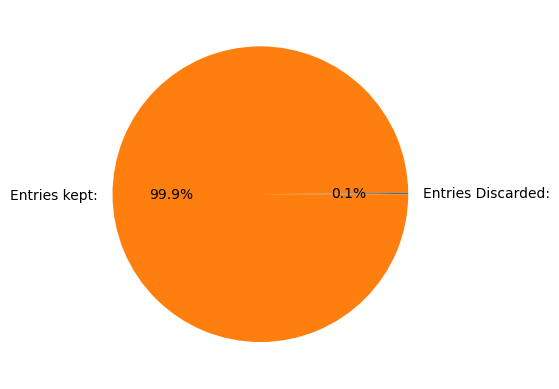

In [ ]:
after_subtask_4 = df.shape[0]
print_distribution(after_subtask_4, counter)

In [ ]:
actual_ranges = {
    #'AMD004' : (40.0, 200.0),
    #'AMD005' : (40.0, 130.0),
    #'AMD007' : (50.0, 500.0),
    #'AMD008' : (5.0, 15.0)
    'STITCH002' : (30.0, 300.0),
    'STITCH003' : (60, 330)
}

In [ ]:
esami_laboratorio_parametri_calcolati.head()

,Unnamed: 0_x,idcentro,idana,data,codiceamd,valore,codicestitch,Unnamed: 0_y
0,133,149,260,2005-09-07,AMD927,26.64,STITCH001,72093
1,134,149,260,2006-12-05,AMD927,25.61,STITCH001,72093
2,135,149,260,2007-06-08,AMD927,26.99,STITCH001,72093
3,136,149,260,2008-02-12,AMD927,26.99,STITCH001,72093
4,137,149,260,2008-08-01,AMD927,27.16,STITCH001,72093


In [ ]:
counter = 0
df = esami_laboratorio_parametri_calcolati
for codicestitch, ranges in actual_ranges.items():
    # get the items with the amd code to be checked
    tmp_amd = df[df['codicestitch'] == codicestitch]
    # get all the other items
    tmp_not_amd = df[df['codicestitch'] != codicestitch]

    counter += tmp_amd[tmp_amd['valore'] < ranges[0]].shape[0] + tmp_amd[tmp_amd['valore'] > ranges[1]].shape[0]

    #if column 'valore' got a value less than than the minimum of the actual range, replace the value with the minimum
    tmp_amd['valore'] = tmp_amd['valore'].apply(lambda x : ranges[0] if x < ranges[0] else x)

    #if column 'valore' got a value more than than the maximum of the actual range, replace the value with the maximum
    tmp_amd['valore'] = tmp_amd['valore'].apply(lambda x : ranges[1] if x > ranges[1] else x)

    df = pd.concat([tmp_amd, tmp_not_amd]).reset_index(drop=True)

Entries kept: 2740195
Entries Discarded: 13843
Entries kept: 0.51 %
Entries Discarded: 0.51 %


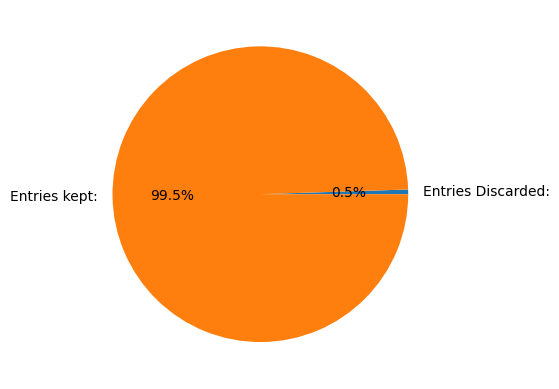

In [ ]:
if save_df:
    df.to_csv(df_path+'new_esami_laboratorio_parametri_calcolati.csv')
esami_laboratorio_parametri_calcolati = df
after_subtask_4 = df.shape[0]
print_distribution(after_subtask_4, counter)

In [ ]:
diagnosi = DFs[0]
prescrizioni_non_diabete = DFs[1]
prescrizioni_diabete_farmaci = DFs[2]
prescrizioni_diabete_non_farmaci = DFs[3]
esami_strumentali = DFs[4]
esami_laboratorio_parametri = DFs[5]
esami_laboratorio_parametri_calcolati = DFs[6]
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

# 5. Cohort selection and label definition

Use only those patients that after all the previous steps contain at least two events before calculating the label. Let P = {p1, . . . , pn} be the set of all patients in the dataset. Let d(eik) be the date of the last event ek for patient pi ∈ P. The label of the patient pi is calculated as follows:

> y(pi) = 1 if, within d(eik) − 6 months, pi has a cardiovascular event

> y(pi) = 0 otherwise

In [ ]:
macro_cardiovascular_events = ['AMD047', 'AMD048', 'AMD049', 'AMD071', 'AMD081', 'AMD082', 'AMD208', 'AMD303']

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_farmaci,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
    esami_laboratorio_parametri_calcolati
]

## 5.1. Patients with TWO events

In [ ]:
initialized = False
for df in DFs:
    tmp_df = df[['idcentro', 'idana']]
    tmp_df = tmp_df.groupby(['idcentro', 'idana']).size().reset_index(name='count')

    tmp_df = tmp_df[tmp_df['count'] > 1] # keep only patients with at least 2 events
    tmp_df = tmp_df.drop(columns=['count'], axis=1).reset_index(drop=True)

    if not initialized:
        two_events_patients = tmp_df
        initialized = True
    else:
        two_events_patients = pd.concat([two_events_patients, tmp_df], ignore_index=True)
        two_events_patients = two_events_patients.drop_duplicates(keep='first').reset_index(drop=True)

In [ ]:
if save_df:
    two_events_patients.to_csv(df_path+'two_events_patients.csv')
two_events_patients.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,61
4,1,65


## 5.2. Latest event for each patient

In [ ]:
initialized = False
for df in DFs:
    tmp_df = df[['idcentro', 'idana', 'data']]
    tmp_df = tmp_df.sort_values('data', ascending=False)
    tmp_df = tmp_df.drop_duplicates(subset=['idcentro', 'idana'], keep='first').reset_index(drop=True)

    if not initialized:
        latest_event = tmp_df
        initialized = True
    else:
        latest_event = pd.concat([latest_event, tmp_df], ignore_index=True)
        latest_event = latest_event.sort_values('data', ascending=False)
        latest_event = latest_event.drop_duplicates(subset=['idcentro', 'idana'], keep='first').reset_index(drop=True)

In [ ]:
if save_df:
    latest_event.to_csv(df_path+'latest_event.csv')
latest_event.head()

,idcentro,idana,data
0,190,889,2019-11-15
1,269,2940,2019-09-30
2,14,408,2019-09-30
3,268,689,2019-09-30
4,32,10802,2019-09-27


## 5.3 Merge

In [ ]:
latest_event.head()

,idcentro,idana,data
0,190,889,2019-11-15
1,269,2940,2019-09-30
2,14,408,2019-09-30
3,268,689,2019-09-30
4,32,10802,2019-09-27


In [ ]:
two_events_patients.head()

,idcentro,idana
0,1,5
1,1,36
2,1,38
3,1,61
4,1,65


In [ ]:
latest_event_patients = filter_df_patients(latest_event, two_events_patients)
if save_df:
    latest_event_patients.to_csv(df_path+'latest_event_patients.csv')

## 5.4. Label patients

In [ ]:
label_patient = two_events_patients

In [ ]:
latest_event.head()

,idcentro,idana,data
0,190,889,2019-11-15
1,269,2940,2019-09-30
2,14,408,2019-09-30
3,268,689,2019-09-30
4,32,10802,2019-09-27
...,...,...,...
49935,11,4494,1992-11-14
49936,74,9452,1992-01-01
49937,11,3449,1990-01-01
49938,104,7001,1986-01-01


In [ ]:
six_months_ago = latest_event

six_months_ago['six_months'] = six_months_ago['data'].apply(lambda x : pd.Timestamp(x) - pd.DateOffset(months=6))

In [ ]:
# if the patient had an event inside macro_cardiovascular_events and after the six_months_ago mark then the label must be 1
def label_patients(diagnosi, six_months_ago, label=1):

    six_months =  six_months_ago[['idcentro','idana','six_months']]

    df = diagnosi

    # only consider macro cardiovascular events
    tmp_df = df[df['codiceamd'].notna()] # only take rows that have a valid code
    tmp_df = tmp_df[tmp_df['codiceamd'].isin(macro_cardiovascular_events)]

    # only connsider events that happened within six months
    tmp_df = pd.merge(tmp_df, six_months, on=['idcentro', 'idana'], how='inner')
    tmp_df = tmp_df.drop_duplicates(subset=['idcentro', 'idana'], keep='first').reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['data'] >= tmp_df['six_months']]

    tmp_df = tmp_df[['idcentro','idana']] # all patients with macrocardiovascular events that happened in the last six months
    tmp_df['label'] = tmp_df['idcentro'].apply(lambda x : 1)

    labeled_1 = tmp_df.drop_duplicates(subset=['idcentro', 'idana'], keep='first').reset_index(drop=True)

    df = df[['idcentro', 'idana']]

    labeled_0 = pd.merge(df[['idcentro','idana']], labeled_1[['idcentro','idana']], indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    labeled_0['label'] = labeled_0['idcentro'].apply(lambda x : 0)
    labeled_0 = labeled_0.drop_duplicates(subset=['idcentro', 'idana'], keep='first').reset_index(drop=True)

    return labeled_1, labeled_0

In [ ]:
label_1, label_0 = label_patients(diagnosi, six_months_ago)
labeled_patients = pd.concat([label_1, label_0], ignore_index=True)
labeled_patients

,idcentro,idana,label
0,1,154,1
1,1,1275,1
2,1,1834,1
3,1,2450,1
4,1,2852,1
...,...,...,...
49907,250,10961,0
49908,251,12146,0
49909,253,9136,0
49910,253,13892,0


label 0 44238
label 1 5674
label 0 12.83 %
label 1 12.83 %


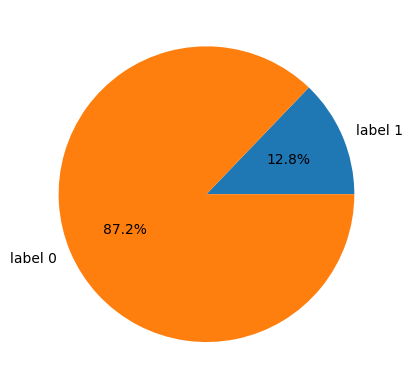

In [ ]:
label_1_patients = labeled_patients[labeled_patients['label'] == 1].shape[0]
label_0_patients = labeled_patients[labeled_patients['label'] == 0].shape[0]
print_distribution(label_0_patients, label_1_patients, "label 0", "label 1")
if save_df:
    labeled_patients.to_csv(df_path+'labeled_patients.csv')

# 6. Merge tasks

## 6.0 Load in the micro-tasks

In [ ]:
# micro-task 1
event_of_interest_patients = pd.read_csv(df_path+'event_of_interest_patients.csv')

In [ ]:
# micro-task 3
long_trajectory_patients = pd.read_csv(df_path+'long_trajectory_patients.csv')

In [ ]:
# micro-task 5
labeled_patients = pd.read_csv(df_path+'labeled_patients.csv')

## 6.1 Merge valid patients in a single file

After all the pruninng we shall now merge all the different lists in a single one, by intersection.

In [ ]:
# merge patients in a single dataframe
final_patients = labeled_patients[['idcentro', 'idana','label']]
final_patients = filter_df_patients(final_patients, long_trajectory_patients)
final_patients = filter_df_patients(final_patients, event_of_interest_patients[['idcentro','idana']])
final_patients = final_patients[['idcentro', 'idana', 'label']]
final_patients = final_patients.drop_duplicates(keep='first').reset_index(drop=True)

In [ ]:
label_1 = final_patients[final_patients['label'] == 1].shape[0]
label_0 = final_patients[final_patients['label'] == 0].shape[0]
label_0, label_1, label_0 > label_1

(61794, 6672, True)

label 0 61794
label 1 6672
label 0 10.8 %
label 1 10.8 %


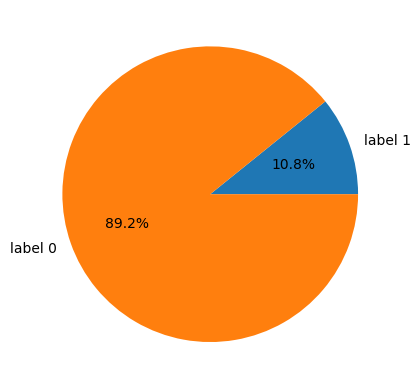

In [ ]:
label_1 = final_patients[final_patients['label'] == 1].shape[0]
label_0 = final_patients[final_patients['label'] == 0].shape[0]
print_distribution(label_0, label_1, 'label 0', 'label 1')

In [ ]:
if save_df:
    final_patients.to_csv(df_path+'final_patients.csv')
final_patients.head()

,idcentro,idana,label
0,1,154,1
1,1,503,1
2,1,1275,1
3,1,1834,1
4,1,2025,1


# 7. Merge all DataFrames

In [ ]:
DFs = [
    diagnosi,
    prescrizioni_non_diabete,
    prescrizioni_diabete_non_farmaci,
    esami_strumentali,
    esami_laboratorio_parametri,
]

In [ ]:
initialized = False
for i in range(len(DFs)):
    df = DFs[i]
    if not initialized:
        final_df = df
        initialized = True
    else:
        final_df = pd.concat([final_df, df]).reset_index(drop=True)

In [ ]:
del DFs
del diagnosi
del prescrizioni_non_diabete
del prescrizioni_diabete_farmaci
del prescrizioni_diabete_non_farmaci
del esami_strumentali
del esami_laboratorio_parametri
del esami_laboratorio_parametri_calcolati

In [ ]:
final_df = pd.merge(final_df, anagrafica_pazienti_attivi, on=['idcentro', 'idana'], how='inner')
del anagrafica_pazienti_attivi

In [ ]:
final_df = final_df[['idcentro', 'idana', 'data', 'codiceamd', 'valore', 'sesso', 'annodiagnosidiabete', 'scolarita', 'statocivile', 'professione', 'origine', 'annonascita']]

In [ ]:
final_patients.head()

,idcentro,idana,label
0,1,154,1
1,1,503,1
2,1,1275,1
3,1,1834,1
4,1,2025,1


In [ ]:
final_df = filter_df_patients(final_df, final_patients)
final_df = pd.merge(final_df, final_patients, on=['idcentro', 'idana'], how='inner')
final_df.drop(columns=['label_y'], inplace=True)
final_df.rename(columns={'label_x':'label'}, inplace=True)
if save_df:
    final_df.to_csv(df_path+'final_df.csv')

In [ ]:
final_df.head()